In [ ]:
!pip install plotly

In [ ]:
!pip install wordcloud

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
import statsmodels.api as sm

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report

In [ ]:

from scipy.stats import pearsonr

import warnings

In [ ]:
merged_df = pd.read_csv('merged_df.csv')

### Distribution of Apple stock closing prices over time

In [ ]:
# Distribution of Apple Closing Prices Over Time
fig = px.histogram(merged_df, x='published_dt_only', y='Close_AAPL',
                   title='Distribution of Apple Closing Prices Over Time',
                   labels={'published_dt_only':'Date', 'Close_AAPL':'Close Price ($)'})

fig.show()


In [ ]:
# Trading Volume vs. Stock Price Volatility

merged_df['Volatility'] = merged_df['High_AAPL'] - merged_df['Low_AAPL']

fig = px.scatter(merged_df, x='Volume_AAPL', y='Volatility',
                 title='Trading Volume vs. Stock Price Volatility',
                 labels={'Volume_AAPL':'Trading Volume', 'Volatility':'Price Volatility'},
                 color='Volatility', size='Volatility', hover_data=['Close_AAPL'])
fig.show()


In [ ]:
#Overall Sentiment Distribution

fig = px.histogram(merged_df, x='sentiment', title='Sentiment Distribution of News Articles',
                   color='sentiment', text_auto=True)
fig.show()


In [ ]:
# Daily Returns & Sentiment
merged_df['Daily_Return'] = merged_df['Close_AAPL'] - merged_df['Open_AAPL']

fig = px.scatter(merged_df, x='sentiment_score', y='Daily_Return',
                 title='Daily Returns vs. Sentiment Score',
                 trendline='ols')
fig.show()


In [ ]:
# Lag Features

merged_df['Sentiment_Lag1'] = merged_df['sentiment_score'].shift(1)
merged_df['Sentiment_Lag7'] = merged_df['sentiment_score'].shift(7)


In [ ]:
merged_df['Sentiment_Binary'] = merged_df['sentiment_score'].apply(lambda x: 1 if x > 0 else 0)
avg_returns = merged_df.groupby('Sentiment_Binary')['Daily_Return'].mean()
avg_returns


,Daily_Return
Sentiment_Binary,
1,-0.099557


In [ ]:
correlation = merged_df[['sentiment_score', 'Daily_Return']].corr()
correlation


,sentiment_score,Daily_Return
sentiment_score,1.000000,-0.006307
Daily_Return,-0.006307,1.000000


In [ ]:
extreme = merged_df[(merged_df['sentiment_score']>0.5) | (merged_df['sentiment_score']<-0.5)]
fig = px.scatter(extreme, x='Volume_AAPL', y='sentiment_score',
                 title='High Volume vs. Extreme Sentiment')
fig.show()


In [ ]:
merged_df['Day_of_Week'] = merged_df['published_dt_only'].dt.day_name()
dow_returns = merged_df.groupby('Day_of_Week')['Daily_Return'].mean()
fig = px.bar(dow_returns, title='Average Returns by Day of Week')
fig.show()


In [ ]:
import plotly.figure_factory as ff

corr = merged_df[['Close_AAPL','Open_AAPL','High_AAPL','Low_AAPL','Volume_AAPL','sentiment_score','Daily_Return']].corr()
fig = ff.create_annotated_heatmap(
    z=corr.values,
    x=list(corr.columns),
    y=list(corr.index),
    colorscale='Viridis'
)
fig.show()


In [ ]:
merged_df['Next_Day_Return'] = merged_df['Daily_Return'].shift(-1)

features = ['Close_AAPL','Volume_AAPL','sentiment_score','Sentiment_Lag1','Sentiment_Lag7']
df_model = merged_df.dropna(subset=features + ['Next_Day_Return'])

X = df_model[features]
y = df_model['Next_Day_Return']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, shuffle=False)

reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

mean_squared_error(y_test, y_pred)


7.659589824332876

In [ ]:
df_model['Next_Day_Up'] = (df_model['Next_Day_Return'] > 0).astype(int)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, df_model.loc[X_train.index,'Next_Day_Up'])
y_pred_class = clf.predict(X_test)

accuracy_score(df_model.loc[X_test.index,'Next_Day_Up'], y_pred_class)


0.25

In [ ]:
importances = clf.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
feat_imp


,0
Sentiment_Lag7,0.250173
Sentiment_Lag1,0.226165
sentiment_score,0.220331
Close_AAPL,0.168046
Volume_AAPL,0.135286


In [ ]:
# Strategy: Buy if sentiment_score > 0, sell if < 0
merged_df['Strategy_Return'] = merged_df['Daily_Return'] * merged_df['Sentiment_Binary'].replace(0,-1)
cumulative_return = merged_df['Strategy_Return'].cumsum()

fig = px.line(merged_df, x='published_dt_only', y=cumulative_return, title='Cumulative Strategy Return')
fig.show()


In [ ]:
# Suppress SettingWithCopyWarning
warnings.filterwarnings('ignore')


df = merged_df.copy()

# Ensure published_dt_only is a datetime object and set as index
df['published_dt_only'] = pd.to_datetime(df['published_dt_only'])
df.set_index('published_dt_only', inplace=True)
df.sort_index(inplace=True)

print("Data loaded and preprocessed successfully.")
print("-" * 50)


# Descriptive Analysis & Visualization ---
print("Performing Descriptive Analysis & Visualization...")

# What is the distribution of Apple stock closing prices over time?
fig1 = px.line(df, x=df.index, y='Close_AAPL', title='Apple Stock Closing Price Over Time',
               labels={'Close_AAPL': 'Closing Price ($)', 'published_dt_only': 'Date'})
fig1.show()

# How does trading volume correlate with stock price volatility?
# Using 'High_AAPL' - 'Low_AAPL' as a simple measure of volatility
df['volatility'] = df['High_AAPL'] - df['Low_AAPL']
fig2 = px.scatter(df, x='Volume_AAPL', y='volatility',
                  title='Volume vs. Volatility',
                  labels={'Volume_AAPL': 'Trading Volume', 'volatility': 'Daily Price Range (Volatility)'},
                  trendline='ols')
fig2.show()

# What is the overall sentiment distribution in the news dataset?
sentiment_counts = df['sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['sentiment', 'count']
fig3 = px.pie(sentiment_counts, values='count', names='sentiment',
              title='Overall Sentiment Distribution',
              color='sentiment',
              color_discrete_map={'positive': 'green', 'neutral': 'blue', 'negative': 'red'})
fig3.show()

# Are there trends in sentiment scores over time?
# Using a daily rolling average to smooth the trend
df['sentiment_score_rolling_avg'] = df['sentiment_score'].rolling(window=7).mean()
fig4 = px.line(df, x=df.index, y='sentiment_score_rolling_avg',
               title='Rolling Average Sentiment Score Over Time',
               labels={'sentiment_score_rolling_avg': '7-Day Rolling Avg Sentiment Score', 'published_dt_only': 'Date'})
fig4.show()

# Which news sources are the most frequent and how does sentiment vary by source?
source_counts = df['source'].value_counts().reset_index()
source_counts.columns = ['source', 'count']
fig5 = px.bar(source_counts, x='source', y='count', title='Most Frequent News Sources')
fig5.show()

sentiment_by_source = df.groupby('source')['sentiment_score'].mean().reset_index()
fig6 = px.bar(sentiment_by_source, x='source', y='sentiment_score',
              title='Average Sentiment Score by News Source',
              labels={'sentiment_score': 'Average Sentiment Score'})
fig6.show()


print("-" * 50)



# Can you compute daily returns and analyze how they relate to sentiment?
df['daily_return'] = df['Close_AAPL'] - df['Open_AAPL']

# Analyze relationship with sentiment (scatter plot)
fig7 = px.scatter(df, x='sentiment_score', y='daily_return',
                  title='Daily Returns vs. Sentiment Score',
                  labels={'sentiment_score': 'Sentiment Score', 'daily_return': 'Daily Return ($)'},
                  trendline='ols')
fig7.show()

# Can you create lag features of sentiment scores?
# Shift sentiment scores to capture previous day/week sentiment
df['sentiment_score_lag1'] = df['sentiment_score'].shift(1)
df['sentiment_score_lag7'] = df['sentiment_score'].shift(7)
print("Lag features for sentiment score created.")

# Can you categorize sentiment into binary labels?
df['sentiment_binary'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0 if x == 'negative' else 0.5)
# This creates a numerical representation for comparison.
print("Sentiment categorized into binary labels (positive=1, negative=0).")
print("-" * 50)


#Statistical Analysis ---
print("Conducting Statistical Analysis...")

# Is there a statistically significant correlation between sentiment scores and stock returns?
# We use the Pearson correlation test which also provides a p-value for significance.
correlation, p_value = pearsonr(df['sentiment_score'].dropna(), df['daily_return'].dropna())
print(f"Pearson Correlation between Sentiment Score and Daily Return: r = {correlation:.4f}, p-value = {p_value:.4f}")
if p_value < 0.05:
    print("The correlation is statistically significant (at 95% confidence).")
else:
    print("The correlation is not statistically significant (at 95% confidence).")

# Does high trading volume coincide with extreme sentiment?
# Extreme sentiment can be measured by the absolute value of the sentiment score
df['extreme_sentiment'] = np.abs(df['sentiment_score'])
correlation_volume_sentiment, p_value_volume_sentiment = pearsonr(df['Volume_AAPL'].dropna(), df['extreme_sentiment'].dropna())
print(f"Pearson Correlation between Volume and Extreme Sentiment: r = {correlation_volume_sentiment:.4f}, p-value = {p_value_volume_sentiment:.4f}")

# Are there certain days of the week where sentiment or returns are consistently higher or lower?
df['day_of_week'] = df.index.day_name()
avg_return_by_day = df.groupby('day_of_week')['daily_return'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
avg_sentiment_by_day = df.groupby('day_of_week')['sentiment_score'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
print("\nAverage Daily Returns by Day of the Week:")
print(avg_return_by_day)
print("\nAverage Sentiment Score by Day of the Week:")
print(avg_sentiment_by_day)
print("-" * 50)


# Visualization & Communication
print("Creating Combined Visualizations...")

# Visualize stock price and sentiment over time on a combined chart
# We'll use plotly's make_subplots to create a secondary y-axis for sentiment score.
fig_combined = make_subplots(specs=[[{"secondary_y": True}]])
fig_combined.add_trace(
    go.Scatter(x=df.index, y=df['Close_AAPL'], name="AAPL Close Price", yaxis='y1',
               line=dict(color='blue')),
    secondary_y=False,
)
fig_combined.add_trace(
    go.Scatter(x=df.index, y=df['sentiment_score_rolling_avg'], name="7-Day Avg Sentiment Score", yaxis='y2',
               line=dict(color='orange')),
    secondary_y=True,
)
fig_combined.update_layout(
    title_text='AAPL Close Price vs. 7-Day Rolling Average Sentiment Score',
    xaxis_title='Date'
)
fig_combined.update_yaxes(title_text="<b>AAPL Close Price ($)</b>", secondary_y=False)
fig_combined.update_yaxes(title_text="<b>Sentiment Score</b>", secondary_y=True)
fig_combined.show()

# Create a heatmap showing correlations
correlation_df = df[['sentiment_score', 'Volume_AAPL', 'daily_return', 'volatility']].corr()
fig_heatmap = px.imshow(correlation_df,
                        text_auto=True,
                        aspect="auto",
                        color_continuous_scale='RdBu_r',
                        title='Correlation Heatmap')
fig_heatmap.show()
print("Combined visualizations created.")
print("-" * 50)


df.reset_index(drop=False, inplace=True)
import pandas as pd
import plotly.express as px


df['published_dt_only'] = pd.to_datetime(df['published_dt_only'])


fig = px.scatter(
    df,
    x='published_dt_only',
    y='Close_AAPL',
    color='sentiment',
    hover_data={
        'title': True,
        'sentiment_score': True,
        'Close_AAPL': ':.2f',
        'published_dt_only': False
    },
    labels={
        'Close_AAPL': 'Closing Price (USD)',
        'published_dt_only': 'Date'
    },
    title='Apple Stock Closing Price Over Time with News Sentiment'
)

# Add connecting line for stock price trend
fig.add_traces(px.line(df, x='published_dt_only', y='Close_AAPL').data)

fig.update_traces(marker=dict(size=10, opacity=0.7), selector=dict(mode='markers'))
fig.update_layout(template="plotly_white", hovermode="closest")

fig.show()


Data loaded and preprocessed successfully.
--------------------------------------------------
Step 2: Performing Descriptive Analysis & Visualization...


Descriptive analysis and visualizations completed.
--------------------------------------------------
Step 3: Performing Feature Engineering...


Lag features for sentiment score created.
Sentiment categorized into binary labels (positive=1, negative=0).
--------------------------------------------------
Step 4: Conducting Statistical Analysis...
Pearson Correlation between Sentiment Score and Daily Return: r = -0.0063, p-value = 0.9061
The correlation is not statistically significant (at 95% confidence).
Pearson Correlation between Volume and Extreme Sentiment: r = -0.0522, p-value = 0.3289

Average Daily Returns by Day of the Week:
day_of_week
Monday      -0.914167
Tuesday      0.001627
Wednesday    0.783971
Thursday    -0.543941
Friday       0.090213
Saturday          NaN
Sunday            NaN
Name: daily_return, dtype: float64

Average Sentiment Score by Day of the Week:
day_of_week
Monday       0.950727
Tuesday      0.936789
Wednesday    0.939118
Thursday     0.966999
Friday       0.943105
Saturday          NaN
Sunday            NaN
Name: sentiment_score, dtype: float64
--------------------------------------------------
Ste

Combined visualizations created.
--------------------------------------------------


In [ ]:

"How does trading volume correlate with stock price volatility?"

df['published_dt_only'] = pd.to_datetime(df['published_dt_only'])
df = df.sort_values('published_dt_only')

# Compute daily volatility (price range)
df['volatility'] = df['High_AAPL'] - df['Low_AAPL']

# Compute correlation
corr, p_value = pearsonr(df['Volume_AAPL'], df['volatility'])
print(f'Pearson Correlation: {corr:.4f} (p-value: {p_value:.4f})')

# Scatter plot for visualization
fig = px.scatter(df, x='Volume_AAPL', y='volatility',
                 trendline='ols',
                 title='Trading Volume vs. Stock Price Volatility',
                 labels={'Volume_AAPL': 'Trading Volume', 'volatility': 'Daily Price Range'})
fig.update_layout(xaxis_title='Trading Volume', yaxis_title='Volatility (High - Low)')
fig.show()






# Bar plot for sentiment distribution
fig = px.histogram(df, x='sentiment',
                   title='Overall Sentiment Distribution',
                   labels={'sentiment': 'Sentiment Category'},
                   category_orders={'sentiment': ['negative', 'neutral', 'positive']})
fig.update_layout(xaxis_title='Sentiment', yaxis_title='Count', bargap=0.1)
fig.show()







"Are there trends in sentiment scores over time, and do they align with major stock movements?"
df['published_dt_only'] = pd.to_datetime(df['published_dt_only'])
df = df.sort_values('published_dt_only')

# Dual-axis line plot
fig = go.Figure()

fig.add_trace(go.Scatter(x=df['published_dt_only'], y=df['sentiment_score'],
                         mode='lines', name='Sentiment Score', yaxis='y1'))

fig.add_trace(go.Scatter(x=df['published_dt_only'], y=df['Close_AAPL'],
                         mode='lines', name='Closing Price', yaxis='y2'))

fig.update_layout(title='Sentiment Scores and Stock Closing Prices Over Time',
                  xaxis_title='Date',
                  yaxis=dict(title='Sentiment Score', titlefont=dict(color='blue')),
                  yaxis2=dict(title='Closing Price (USD)', titlefont=dict(color='red'), overlaying='y', side='right'))
fig.show()

# Rolling correlation (e.g., 30-day window)
df['rolling_corr'] = df['sentiment_score'].rolling(30).corr(df['Close_AAPL'])
print(df['rolling_corr'].describe())





"Which news sources are the most frequent and how does sentiment vary by source?"
# Most frequent sources
source_counts = df['source'].value_counts().reset_index()
source_counts.columns = ['source', 'count']
print('Top Sources:\n', source_counts.head(10))

# Bar plot for frequency
fig_bar = px.bar(source_counts.head(10), x='source', y='count',
                 title='Top 10 Most Frequent News Sources')
fig_bar.show()

# Box plot for sentiment by source (top 10 only for clarity)
top_sources = source_counts['source'].head(10)
df_top = df[df['source'].isin(top_sources)]
fig_box = px.box(df_top, x='source', y='sentiment_score',
                 title='Sentiment Score Variation by News Source')
fig_box.update_layout(xaxis_title='Source', yaxis_title='Sentiment Score')
fig_box.show()






"Compute daily returns (Close_AAPL - Open_AAPL) and analyze how they relate to sentiment"
df['daily_return'] = df['Close_AAPL'] - df['Open_AAPL']

# Correlation
corr, p_value = pearsonr(df['daily_return'].dropna(), df['sentiment_score'].dropna())
print(f'Correlation between Daily Returns and Sentiment: {corr:.4f} (p-value: {p_value:.4f})')

# Scatter plot
fig = px.scatter(df, x='sentiment_score', y='daily_return',
                 trendline='ols', title='Daily Returns vs. Sentiment Score')
fig.show()





"Create lag features of sentiment scores (previous day/week) to capture delayed market reactions"

df['published_dt_only'] = pd.to_datetime(df['published_dt_only'])
df = df.sort_values('published_dt_only')

df['lag1_sentiment'] = df['sentiment_score'].shift(1)  # Previous day
df['lag5_sentiment'] = df['sentiment_score'].shift(5)  # Previous week (approx)








Pearson Correlation: 0.6952 (p-value: 0.0000)


count    319.000000
mean      -0.027600
std        0.174855
min       -0.475091
25%       -0.138267
50%       -0.019772
75%        0.099478
max        0.341330
Name: rolling_corr, dtype: float64
Top Sources:
         source  count
0  Google News    352


Correlation between Daily Returns and Sentiment: -0.0063 (p-value: 0.9061)


In [ ]:
from scipy.stats import pearsonr
"Is there a statistically significant correlation between sentiment scores and stock returns?"
# Assuming df with 'sentiment_score' and 'daily_return'
corr, p_value = pearsonr(df['sentiment_score'], df['daily_return'])
print(f'Correlation: {corr:.4f}, p-value: {p_value:.4f}')
if p_value < 0.05:
    print('Statistically significant.')
else:
    print('Not significant.')

Correlation: -0.0063, p-value: 0.9061
Not significant.


In [ ]:
"Does high trading volume coincide with extreme sentiment (very positive or very negative)?"
df['extreme_sent'] = abs(df['sentiment_score']) > 0.5

# Mean volumes
mean_vol = df.groupby('extreme_sent')['Volume_AAPL'].mean().reset_index()
print(mean_vol)

fig = px.bar(mean_vol, x='extreme_sent', y='Volume_AAPL',
             title='Average Trading Volume by Extreme Sentiment')
fig.show()

   extreme_sent   Volume_AAPL
0          True  5.357579e+07


In [ ]:
import pandas as pd
import plotly.express as px
"Are there certain days of the week where sentiment or returns are consistently higher or lower?"

df['day_of_week'] = df['published_dt_only'].dt.day_name()

# Means
means = df.groupby('day_of_week')[['sentiment_score', 'daily_return']].mean().reset_index()

fig_sent = px.bar(means, x='day_of_week', y='sentiment_score', title='Average Sentiment by Day of Week')
fig_sent.show()

fig_ret = px.bar(means, x='day_of_week', y='daily_return', title='Average Returns by Day of Week')
fig_ret.show()

In [ ]:
import pandas as pd
import plotly.express as px
"Create a heatmap showing correlations between sentiment, volume, and price changes"
corr = df[['sentiment_score', 'Volume_AAPL', 'daily_return', 'volatility']].corr()

fig = px.imshow(corr, text_auto=True, aspect='auto',
                title='Correlation Heatmap: Sentiment, Volume, and Price Changes')
fig.update_layout(xaxis_title='Features', yaxis_title='Features')
fig.show()

In [ ]:
import pandas as pd
import plotly.express as px
"based on sentiment and stock trends, suggest a data-driven trading strategy and evaluate its hypothetical performance"
df['signal'] = 0
df.loc[(df['sentiment_score'] > 0.2) & (df['lag1_sentiment'] > 0), 'signal'] = 1  # Buy
df.loc[(df['sentiment_score'] < -0.2) & (df['lag1_sentiment'] < 0), 'signal'] = -1  # Sell

# Hypothetical returns (assume 1 unit traded, ignore fees)
df['strategy_return'] = df['signal'].shift(1) * df['daily_return'] / df['Open_AAPL']  # Percentage return
df['cumulative_return'] = (1 + df['strategy_return'].fillna(0)).cumprod() - 1

print('Total Hypothetical Return:', df['cumulative_return'].iloc[-1])

fig = px.line(df, x='published_dt_only', y='cumulative_return', title='Hypothetical Strategy Performance')
fig.show()

Total Hypothetical Return: -0.17274367991432293


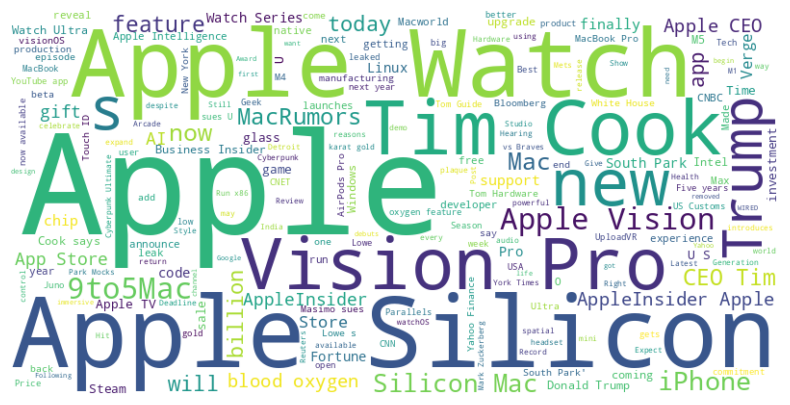

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
"Word Cloud from News Titles:"
text = ' '.join(df['title'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
fig = px.histogram(df, x='daily_return', title='Distribution of Intra-Day Price Changes')
fig.show()
"""
Intra-Day Price Movement Distribution: Histogram of (Close - Open) to see if Apple tends to close higher.
Worth it: Shows bullish/bearish bias.
"""

In [ ]:
"""
Seasonal Trends (Monthly Averages): Group by month for returns/sentiment. Worth it:
 Detects patterns like end-of-year rallies.
"""

df['month'] = df['published_dt_only'].dt.month
monthly = df.groupby('month')[['daily_return', 'sentiment_score']].mean().reset_index()
fig = px.line(monthly, x='month', y=['daily_return', 'sentiment_score'], title='Monthly Averages')
fig.show()

In [ ]:
"""
Outlier Detection in Volume or Prices

"""

fig = px.box(df, y=['Volume_AAPL', 'Close_AAPL'], title='Outliers in Volume and Closing Prices')
fig.show()

In [ ]:
"""
Sentiment vs. Volatility
"""
fig = px.scatter(df, x='sentiment_score', y='volatility', title='Sentiment vs. Volatility')
fig.show()